In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline

In [33]:
df = pd.read_csv('/Users/dominicdebiaso/Development/datasets/dsc_conversion_data.csv')

# EDA

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
df.country.value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [7]:
df.source.value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

In [8]:
# Investigate age max of 123
df.age.sort_values().unique()

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123])

In [9]:
# Two outlier ages which make up only two entries
df[df.age > 79]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [34]:
# Safe to remove them
df = df[df.age < 80]

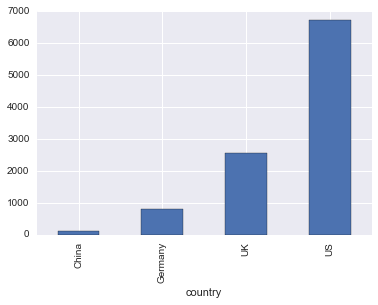

In [11]:
# No. Converted by Country
df.groupby(['country'])['converted'].sum().plot(kind='bar')

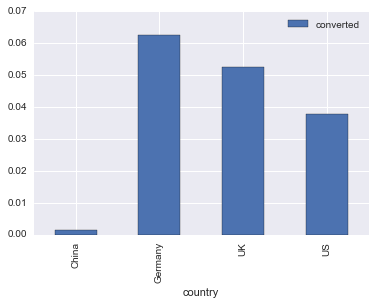

In [12]:
# Converted Rate by Country
df.groupby('country')['converted'].mean().to_frame().plot(kind='bar')

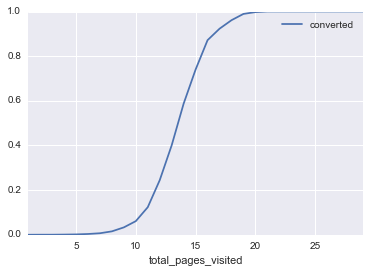

In [13]:
# Converted rate by Total Pages Visited
df.groupby('total_pages_visited')['converted'].mean().to_frame().plot(kind='line')

In [14]:
# Correlation between variables
df.corr(method='spearman')

,age,new_user,total_pages_visited,converted
age,1.000000,0.012111,-0.026120,-0.091825
new_user,0.012111,1.000000,-0.048358,-0.152338
total_pages_visited,-0.026120,-0.048358,1.000000,0.293397
converted,-0.091825,-0.152338,0.293397,1.000000


# ML

In [14]:
# Define X and y
X = df.drop('converted', axis=1)
print(X.shape)
y = df.converted
print(y.shape)

# Convert categorical variables
le = LabelEncoder()
X.country = le.fit_transform(X.country)
X.source = le.fit_transform(X.source)

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(316198, 5)
(316198,)
(237148, 5)
(237148,)
(79050, 5)
(79050,)


In [161]:
# Null Model, predicting most common with dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred_class = dummy_clf.predict(X_test)
print 'Null model accuracy score:', (accuracy_score(y_test, y_pred_class))

Null model accuracy score: 0.968412397217


In [166]:
# Random Forest model
forest_clf = RandomForestClassifier()
# forest_clf.get_params().keys() #what parameters are present

# Build parameter grid of desired hyperparameters
param_grid = {'n_estimators': [50, 100, 200],
              'max_features': [2, 3, 4, 'auto']}
grid = GridSearchCV(forest_clf, param_grid)
%time grid.fit(X_train, y_train)
print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)
grid.grid_scores_

Grid best score: 0.984262991887
Grid best parameters: {'max_features': 3, 'n_estimators': 200}


[mean: 0.98410, std: 0.00021, params: {'max_features': 2, 'n_estimators': 50},
 mean: 0.98409, std: 0.00015, params: {'max_features': 2, 'n_estimators': 100},
 mean: 0.98414, std: 0.00021, params: {'max_features': 2, 'n_estimators': 200},
 mean: 0.98400, std: 0.00013, params: {'max_features': 3, 'n_estimators': 50},
 mean: 0.98414, std: 0.00021, params: {'max_features': 3, 'n_estimators': 100},
 mean: 0.98426, std: 0.00023, params: {'max_features': 3, 'n_estimators': 200},
 mean: 0.98397, std: 0.00023, params: {'max_features': 4, 'n_estimators': 50},
 mean: 0.98416, std: 0.00026, params: {'max_features': 4, 'n_estimators': 100},
 mean: 0.98423, std: 0.00028, params: {'max_features': 4, 'n_estimators': 200},
 mean: 0.98404, std: 0.00022, params: {'max_features': 'auto', 'n_estimators': 50},
 mean: 0.98409, std: 0.00013, params: {'max_features': 'auto', 'n_estimators': 100},
 mean: 0.98423, std: 0.00024, params: {'max_features': 'auto', 'n_estimators': 200}]

In [179]:
# Predict with test data
y_pred_class = grid.predict(X_test) #grid uses best params

# Review metrics of model
print 'Accuracy score:', (accuracy_score(y_test, y_pred_class))
print 'Classification report:', (classification_report(y_test, y_pred_class))
print 'Confusion matrix:', (confusion_matrix(y_test, y_pred_class))

Variable importance: [('country', 0.052838413278518806), ('age', 0.10627030083730669), ('new_user', 0.039148469351845815), ('source', 0.024250149192977001), ('total_pages_visited', 0.77749266733935163)]
Accuracy score: 0.984642631246
Classification report:              precision    recall  f1-score   support

          0       0.99      0.99      0.99     76553
          1       0.80      0.68      0.74      2497

avg / total       0.98      0.98      0.98     79050

Confusion matrix: [[76132   421]
 [  793  1704]]


AUC score: 0.838459722396


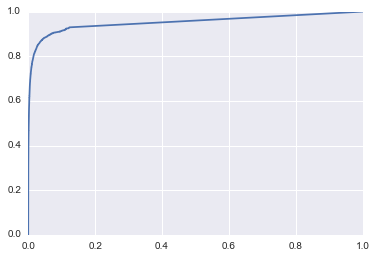

In [180]:
# Retrieve model with probabilities instead of class
y_pred_prob = grid.predict_proba(X_test)[:,1] #choose those in the second slot

# Get False Positive rate and True Positive rate
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
print 'AUC score:', (roc_auc_score(y_test, y_pred_class))

In [181]:
# Predicting with Extra Trees model
forest_clf = ExtraTreesClassifier()

# Build parameter grid of desired hyperparameters
param_grid = {'n_estimators': [50, 100, 200],
              'max_features': [2, 3, 4, 'auto']}
grid = GridSearchCV(forest_clf, param_grid)
%time grid.fit(X_train, y_train)
print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)
grid.grid_scores_

CPU times: user 3min 46s, sys: 3.91 s, total: 3min 50s
Wall time: 3min 50s
Grid best score: 0.983938300133
Grid best parameters: {'max_features': 'auto', 'n_estimators': 50}


[mean: 0.98391, std: 0.00010, params: {'max_features': 2, 'n_estimators': 50},
 mean: 0.98393, std: 0.00010, params: {'max_features': 2, 'n_estimators': 100},
 mean: 0.98390, std: 0.00010, params: {'max_features': 2, 'n_estimators': 200},
 mean: 0.98387, std: 0.00014, params: {'max_features': 3, 'n_estimators': 50},
 mean: 0.98385, std: 0.00013, params: {'max_features': 3, 'n_estimators': 100},
 mean: 0.98388, std: 0.00015, params: {'max_features': 3, 'n_estimators': 200},
 mean: 0.98386, std: 0.00016, params: {'max_features': 4, 'n_estimators': 50},
 mean: 0.98382, std: 0.00014, params: {'max_features': 4, 'n_estimators': 100},
 mean: 0.98388, std: 0.00010, params: {'max_features': 4, 'n_estimators': 200},
 mean: 0.98394, std: 0.00014, params: {'max_features': 'auto', 'n_estimators': 50},
 mean: 0.98392, std: 0.00008, params: {'max_features': 'auto', 'n_estimators': 100},
 mean: 0.98393, std: 0.00013, params: {'max_features': 'auto', 'n_estimators': 200}]

In [182]:
# Predict with test data
y_pred_class = grid.predict(X_test) #grid uses best params

# Review metrics of model
print 'Accuracy score:', (accuracy_score(y_test, y_pred_class))
print 'Classification report:', (classification_report(y_test, y_pred_class))
print 'Confusion matrix:', (confusion_matrix(y_test, y_pred_class))

Accuracy score: 0.984617330803
Classification report:              precision    recall  f1-score   support

          0       0.99      1.00      0.99     76553
          1       0.82      0.66      0.73      2497

avg / total       0.98      0.98      0.98     79050

Confusion matrix: [[76189   364]
 [  852  1645]]


AUC score: 0.827017836476


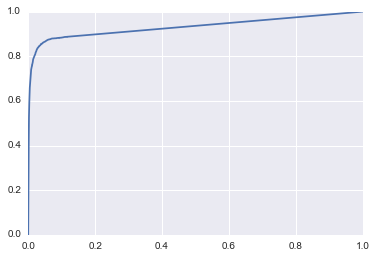

In [183]:
# Retrieve model with probabilities instead of class
y_pred_prob = grid.predict_proba(X_test)[:,1] #choose those in the second slot

# Get False Positive rate and True Positive rate
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
print 'AUC score:', (roc_auc_score(y_test, y_pred_class))

In [ ]:
# http://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn

# ML Updates

In [185]:
# predict using best params
forest_clf = RandomForestClassifier(n_estimators=200, max_features=3)
forest_clf.fit(X_train, y_train)

# Feature importance
importances = forest_clf.feature_importances_
zip(X.columns, importances)

[('country', 0.053575288098482166),
 ('age', 0.10650314613465182),
 ('new_user', 0.039779730260826679),
 ('source', 0.024115332097024211),
 ('total_pages_visited', 0.77602650340901524)]

In [199]:
# Remove total_pages_visited since it may be influencing scores
X_train.drop('total_pages_visited', axis=1, inplace=True)
X_test.drop('total_pages_visited', axis=1, inplace=True)

# New modeling
forest_clf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 200],
              'max_features': [2, 3, 4, 'auto'],
              'class_weight': ['balanced', 'balanced_subsample', None]}
grid = GridSearchCV(forest_clf, param_grid)
grid.fit(X_train, y_train)
print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)

y_pred_class = grid.predict(X_test)
print 'Accuracy score:', (accuracy_score(y_test, y_pred_class))

y_pred_prob = grid.predict_proba(X_test)[:,1] 
print 'AUC score:', (roc_auc_score(y_test, y_pred_class))

Grid best score: 0.967509740753
Grid best parameters: {'max_features': 2, 'n_estimators': 50, 'class_weight': None}
Accuracy score: 0.968412397217
AUC score: 0.5


/Users/dominicdebiaso/Development/virtualenvs/generalenv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/dominicdebiaso/Development/virtualenvs/generalenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [207]:
# plot_partial_dependence(forest_clf, X_train, y_train, feature_names=X_train.columns)

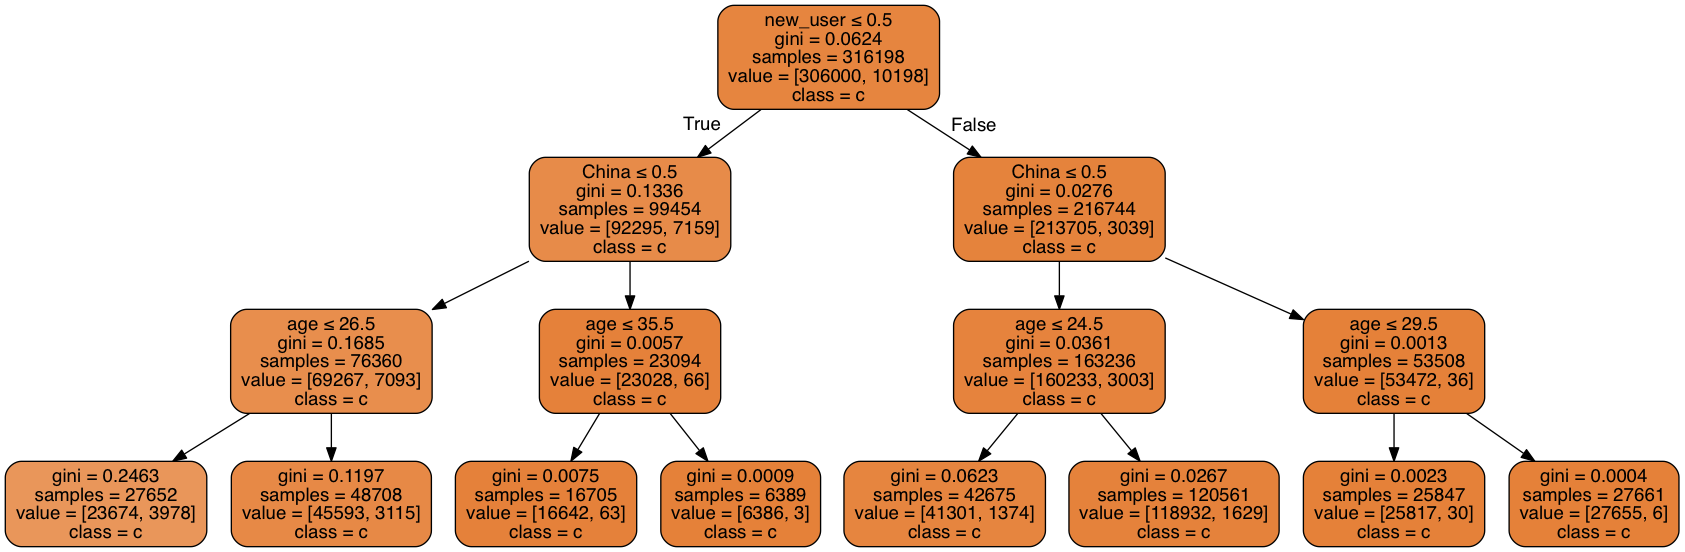

In [57]:
df_country = pd.get_dummies(df.country)
df_source = pd.get_dummies(df.source)
df_new = pd.concat([df, df_country, df_source], axis=1).drop(['country', 'source', 'total_pages_visited'], axis=1)

# Understanding tree structure
tree_clf = tree.DecisionTreeClassifier(max_depth=3)
tree_clf.fit(df_new.drop('converted', axis=1), df_new.converted)

from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(tree_clf, out_file=dot_data, 
                     feature_names=df_new.drop('converted', axis=1).columns, class_names='converted', 
                     filled=True, rounded=True, 
                     special_characters=True)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())